### IMPORT PACKAGES


In [ ]:
from gymnasium.envs.registration import register
import gymnasium as gym
from stable_baselines3 import *

# from stable_baselines3 import A2C
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
import torch as th

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
# from gymnasium.utils import seeding
from enum import Enum
import pandas as pd
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from enum import Enum
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/Users/newuser/Projects/robust-algo-trader/data/trades_EURUSD_H1_2011_2022.csv")
# df = pd.read_csv("C:/Users/da2343/Projects/robust_algo_trader/data/EURUSD/trades_EURUSD_H1_2011_2022.csv")

In [ ]:
df

In [ ]:
"""
# Assuming your pandas dataframe is called df and your label column is called label
# Import pandas and sklearn.metrics
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score

# Shift the label column upwards by one row and assign it to a new column called predicted
df['predicted'] = df['label'].shift(1)

# Drop the last row of the dataframe as it will have a missing value for predicted
df = df.dropna()

# Calculate the accuracy and precision scores between the label and predicted columns
accuracy = accuracy_score(df['label'], df['predicted'])
precision = precision_score(df['label'], df['predicted'])

# Print the results
print(f"Accuracy score: {accuracy}")
print(f"Precision score: {precision}")
"""

In [ ]:
df

In [59]:
class TradeUpdateEnv(gym.Env):
    def __init__(self,  df, window_size, frame_bound):
        assert len(frame_bound) == 2
        assert frame_bound[0] >= window_size
        assert frame_bound[1] > frame_bound[0]
        
        self.frame_bound = frame_bound
        
        # self.seed()
        self.df = df
        self.window_size = window_size
        self.signal_features = self._process_data()
        # print("self.signal_features")
        # print(self.signal_features)
        
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.observation_space = spaces.Box(low=-100, 
                                            high=100,
                                            shape=self.shape, 
                                            dtype=np.float64)
        self.action_space = spaces.Discrete(2)

        # episode
        self._start_tick = 0
        self._current_tick = self._start_tick
        self._last_final_tick = len(self.signal_features) - 1
        self._end_tick = None
        self._terminated = None
        self._truncated = False
        self._total_reward = 0
        self._total_profit = None
        self._prev_loss = False


    def _process_data(self):
        features_df = self.df[["position", "RSI", "ATR", "ADX", "AROON_Oscillator", "MFI","label"]]
        # features_df = self.df[["position", "RSI", "label"]]
        # print(features_df)
        features_df['label'] = features_df['label'].shift(1)
        # print(features_df)
        features_df = features_df.iloc[1:]
        # print the last row
        # print(features_df.iloc[-1])
        features_np = features_df.to_numpy()
        _start_index = self.frame_bound[0] - self.window_size
        _end_index = self.frame_bound[1]
        signal_features = features_np[_start_index:_end_index]
        return signal_features

    def _get_observation(self):
        _start_index = self._current_tick
        _end_index = self._current_tick + self.window_size 
        _obs = self.signal_features[_start_index:_end_index]
        return _obs


    def reset(self, seed=None, options=None):
        super().reset(seed=1)
        self._terminated = False
        self._truncated = False
        self._prev_loss = False
        self._end_tick = self._current_tick + 30
        observation = self._get_observation()
        info = {'total_reward': self._total_reward}
        return observation, info


    def step(self, action):
        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        info = dict(total_reward = self._total_reward)
        # set done flag to True if episode ended because of tick limit
        if self._current_tick == self._end_tick:
            self._terminated = True
        # set truncated flag to True if episode ended because of tick limit
        self._current_tick += 1
        
        if self._current_tick >= (self._last_final_tick - self.window_size  ):
            self._truncated = True
            # reset the current tick to the start tick
            self._current_tick = self._start_tick

        observation = self._get_observation()
        return observation, step_reward, self._terminated, self._truncated, info


    def _calculate_reward(self, action):
        step_reward = 0
        label_index = self._current_tick + self.window_size 
        label_action = self.signal_features[label_index][6]
        
        # label_action = self.signal_features[self._current_tick+1][2]
        # if action == label_action:
        #     step_reward += 1
    
        if action == 1 and label_action == 0:
            step_reward += -1
            if self._prev_loss == True:
                step_reward += -2
            self._prev_loss = True
            # print("lost")
        else:
            self._prev_loss = False
        # else:
            # step_reward += 0.1
            # print("nothing")
            
        if action == 1 and label_action == 1:
            step_reward += 1.5
            # print("won")
    
        return step_reward

# env = TradeUpdateEnv(
#        df = deepcopy(df),
#        window_size = 3,
#        frame_bound = (4, 3000)
# )

In [ ]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=10_000,
  save_path="./log_10_17/",
  name_prefix="trade_drl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

# policy_kwargs = dict(activation_fn=th.nn.ReLU,
#                      net_arch=dict(pi=[128, 128], vf=[128, 128]))

# policy_kwargs = dict(
#     net_arch=[256, 64, 64], # The number and size of the hidden layers
#     activation_fn=th.nn.Tanh, # The activation function
#     lstm=50 # The size of the LSTM cell
# )

policy_kwargs=dict(
    net_arch=[256, 128, 128, 64],
    activation_fn=th.nn.Tanh,
          # lstm_hidden_size=64,
      )

model = RecurrentPPO('MlpLstmPolicy', 
                     env, 
                     verbose=1, 
                    gamma=0.01,
                    gae_lambda = 0.9,
                    #gamma=0,
                    #n_epochs=1000,
                    seed=1,                 
                    #policy_kwargs = policy_kwargs, 
                    device="cuda",
                    tensorboard_log="./trade_env_tensorboard/")
# model.policy
model.learn(total_timesteps=1_000_000_000,  
            log_interval=10, 
            tb_log_name="trade_drl_experiment",
            callback=checkpoint_callback,
            )

In [ ]:
from sb3_contrib import RecurrentPPO

# Load the model from a zip file
# model = RecurrentPPO.load("C:/Users/da2343/Projects/robust_algo_trader/drl/log_10_17/trade_drl_model_44040000_steps.zip")
model = RecurrentPPO.load("/Users/newuser/Projects/robust-algo-trader/envs/trade_drl_model_9120000_steps.zip")
model
# set the env of the saved_model
#saved_model.set_env(env, force_reset=False)

In [81]:

test_env = TradeUpdateEnv(
         df = deepcopy(df),
         window_size = 3,
         frame_bound = (4, 50))

# train_env = TradeUpdateEnv(
#             df = deepcopy(df),
#             window_size = 3,
#             frame_bound = (4, 3000))

algo_list = [
    
    #  {
    #     "name" : "Baseline_Frequent_Label",
    #     "env" : test_env,
    #     "get_action" : lambda env, obs: np.bincount((obs[:,6]).astype(int)).argmax()
        
    # },
    {
        "name" : "Baseline_Random_Label",
        "env" : test_env,
        "get_action" : lambda env, obs: env.action_space.sample()
    },
      {
        "name" : "Baseline_Fixed_Label",
        "env" : test_env,
        "get_action" : lambda env, obs: 1
    },
    {
        "name" : "Baseline_Most_Recent_Label",
        "env" : test_env,
        "get_action" : lambda env, obs: obs[-1][6]
    },
    {
        "name" : "RecurrentPPO",
        "env" : test_env,
        "get_action" : None   
    },
    {
        "name" : "Ensemble_Baseline_Most_Recent_Label_RecurrentPPO",
        "env" : test_env,
        "get_action" : lambda env, obs: obs[-1][6]
    },
    {
        "name" : "Max_Reward",
        "env" : test_env,
        "get_action" : lambda env, obs: 1,
    }
    
]

reward_df_list = []
for index, algo_dict in enumerate(algo_list):
    env = algo_dict['env']
    name = algo_dict['name']
    get_action = algo_dict['get_action']
    observation, info = env.reset()
    episode_count = 0
    step_count = 0
    step_reward_list = []
    lstm_states = None
    num_envs = 1
    # Episode start signals are used to reset the lstm states
    episode_starts = np.ones((num_envs,), dtype=bool)
    

    while True:
        step_count += 1
        
        if get_action == None or name == "Ensemble_Baseline_Most_Recent_Label_RecurrentPPO":
            action, lstm_states = model.predict(observation,state=lstm_states, 
                                             episode_start=episode_starts, 
                                            deterministic=True)
            if name == "Ensemble_Baseline_Most_Recent_Label_RecurrentPPO":
                action_alt = get_action(env, observation)
                # make action 1 if both action and action_alt are 1
                if action == 1 and action_alt == 1:
                    action = 1
                else:
                    action = 0
        else:
            action = get_action(env, observation)
        
        observation, reward, terminated, truncated, info = env.step(action)
        if reward == -3:
            reward = -1
        if name == "Max_Reward":            
            leaky_label = int(observation[-1][6])
            reward = 1.5 if leaky_label == 1 else 0
        # print(action)
        # print(reward)
        step_reward_list.append({
            "step": step_count,
            # f"{name}_reward": reward,
            f"{name}": reward,
            # "reward": reward,
        })
        
        # print("info:", info)
        if terminated:
            episode_count += 1
        # observation, reward, done, info = env.step(action)
        # env.render()
        if truncated:
            # print("name:", name)
            # print("info:", info)
            # print("episode_count:", episode_count)
            # print("step_count:", step_count)
            reward_df = pd.DataFrame(step_reward_list)
            reward_df[name] = reward_df[name].cumsum()
            # remove reward column
            # reward_df = reward_df.drop(columns=["reward"])
            reward_df_list.append(reward_df)
            break
    # add cumulative reward column
reward_df_concat = pd.concat(reward_df_list, axis=1)


In [77]:
reward_df_concat

,step,Baseline_Random_Label,step,Baseline_Fixed_Label,step,Baseline_Most_Recent_Label,step,RecurrentPPO,step,Ensemble_Baseline_Most_Recent_Label_RecurrentPPO,step,Max_Reward
0,1,0.0,1,-1.0,1,-1.0,1,-1.0,1,-1.0,1,0.0
1,2,0.0,2,0.5,2,-1.0,2,-1.0,2,-1.0,2,1.5
2,3,-1.0,3,-0.5,3,-2.0,3,-1.0,3,-1.0,3,1.5
3,4,0.5,4,1.0,4,-2.0,4,0.5,4,-1.0,4,3.0
4,5,0.5,5,0.0,5,-3.0,5,0.5,5,-1.0,5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
190,191,-9.5,191,9.0,191,-28.5,191,1.5,191,-13.5,191,120.0
191,192,-9.5,192,10.5,192,-28.5,192,3.0,192,-13.5,192,121.5
192,193,-10.5,193,9.5,193,-29.5,193,3.0,193,-13.5,193,121.5
193,194,-10.5,194,11.0,194,-29.5,194,4.5,194,-13.5,194,123.0


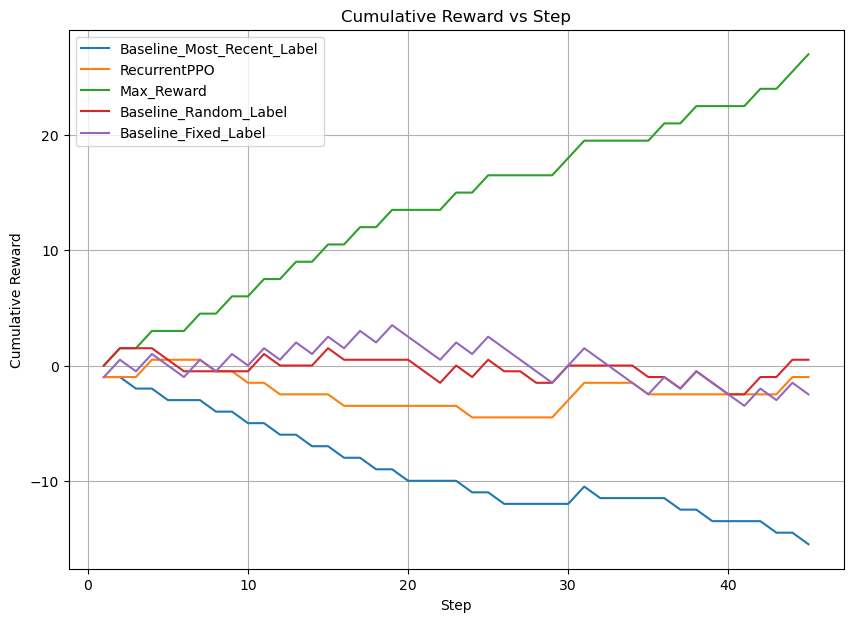

In [82]:
reward_df_concat = pd.concat(reward_df_list, axis=1)
# there are three columns with the same name "step", we only need one
reward_df_concat = reward_df_concat.loc[:,~reward_df_concat.columns.duplicated()]
reward_df_concat

import matplotlib.pyplot as plt

# plot the cumulative reward against the step
plt.figure(figsize=(10, 7))
plt.plot(reward_df_concat["step"], reward_df_concat["Baseline_Most_Recent_Label"], label="Baseline_Most_Recent_Label")
plt.plot(reward_df_concat["step"], reward_df_concat["RecurrentPPO"], label="RecurrentPPO")
plt.plot(reward_df_concat["step"], reward_df_concat["Max_Reward"], label="Max_Reward")
plt.plot(reward_df_concat["step"], reward_df_concat["Baseline_Random_Label"], label="Baseline_Random_Label")
plt.plot(reward_df_concat["step"], reward_df_concat["Baseline_Fixed_Label"], label="Baseline_Fixed_Label")

# plt.plot(reward_df_concat["step"], reward_df_concat["Baseline_Frequent_Label"], label="Baseline_Frequent_Label")
# plt.plot(reward_df_concat["step"], reward_df_concat["Ensemble_Baseline_Most_Recent_Label_RecurrentPPO"], label="Ensemble_Baseline_Most_Recent_Label_RecurrentPPO")

plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward vs Step")

# show grid lines
plt.grid()


plt.legend()
plt.show()